# Ewaluacja predykcji szeregów czasowych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
def check_time_series_stationary(y, rolling_len=12):
    
    y = pd.Series(y)
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    
    pd.plotting.autocorrelation_plot(y)
    plt.show()

In [3]:
usgdp = pd.read_csv('../data/USGDP.csv', parse_dates=['DATE'], index_col='DATE')
usgdp.head()

,GDPC1
DATE,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017


Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     2.9819
p-value             :     1.0000
--------------------------------



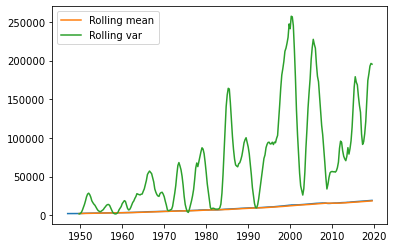

      Autocorrelation plot      
--------------------------------



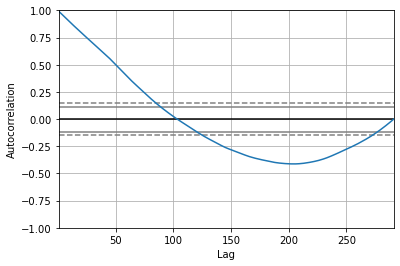

In [4]:
check_time_series_stationary(usgdp.GDPC1)

### Podział na część treningową i część testową

Ocena dokładności na podstawie tych samych danych, które były wykorzystane do konstrukcji prognozu, nie pozwala na w pełni wiarygodną ocenę skuteczności i może prowadzić do błędnych wniosków. Aby wiarygodnie porównać skuteczność różnych metod prognozowania, powinniśmy wykorzystać niezależne dane testowe.

W tym celu szereg dzielimy na:
- **część treningową** - wykorzystaną do dopasowania modelu i konstrukcji prognoz,
- **część testową** - wykorzystaną do oceny dokładności prognoz.

In [5]:
k = int(0.8 * usgdp.GDPC1.size)  # podział danych
usgdp_train, usgdp_test = usgdp[:k], usgdp[k:]

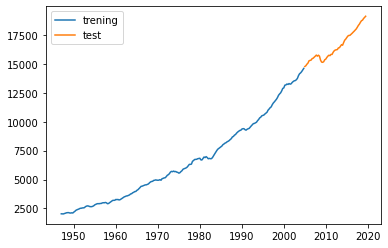

In [6]:
plt.plot(usgdp_train, label='trening')
plt.plot(usgdp_test, label='test')

plt.legend()
plt.show()

In [7]:
log_usgdp_train = np.log(usgdp_train)

m1 = ARIMA(endog=log_usgdp_train, order=(3, 1, 2), trend='t').fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  232
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 758.409
Date:                Mon, 05 Jun 2023   AIC                          -1502.817
Time:                        22:38:54   BIC                          -1478.720
Sample:                    01-01-1947   HQIC                         -1493.098
                         - 10-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0085      0.001     16.995      0.000       0.008       0.010
ar.L1          1.0918      0.343      3.186      0.001       0.420       1.763
ar.L2         -0.0032      0.439     -0.007      0.994      -0.863       0.857
ar.L3         -0.2463      0.126     -1.949      0.051      -0.494       0.001
ma.L1         -0.7978      0.348     -2.291      0.022      -1.480      -0.115
ma.L2         -0.0841      0.337     -0.250      0.803      -0.744       0.576
sigma2      8.218e-05   5.79e-06     14.203      0.000    7.08e-05    9.35e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                27.16
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# usgdp_test
predict_test = np.exp(m1.predict(start='2005-01-01', end='2019-07-01', dynamic=True))  # przewidywanie na podstawie modelu

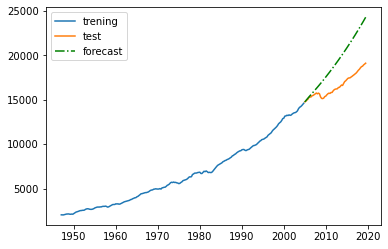

In [9]:
# część testowa odbiega od zachowania części treningowej, stąd duży błąd przewidywania

plt.plot(usgdp_train, label='trening')
plt.plot(usgdp_test, label='test')
plt.plot(predict_test, 'g-.', label='forecast')

plt.legend()
plt.show()

# Predykcja z wykorzystaniem danych historycznych
- tutaj tworzymy predykcję dla obserwacji na podstawie struktury opisanej w modelu i konkretnych danych, które mają wcześniejsze indeksy czasowe
- w kolejnym kroku nie bierzemy predykcji, którą uzyskaliśmy dla wcześniejszej obserwacji, tylko prawdziwą wartość szeregu 

In [ ]:
# ALTERNATYWNIE: przewidywanie na podstawie danych historycznych
# predict_test = np.exp(m1.predict(start='2005-01-01', end='2019-07-01', dynamic=False))  

In [52]:
history = log_usgdp_train.values.tolist()

prediction = []
simple_prediction = []
errors = []

test = usgdp_test.values

for t in range(len(test)):
    
    model = ARIMA(history, order=(3, 1, 2)).fit()
    pred = np.exp(model.forecast()[0])
    prediction.append(pred)
    
    simple_prediction.append(np.exp(history[-1][0]))
    history.append(np.log(test[t]))
    
    errors.append((pred - test[t])**2)

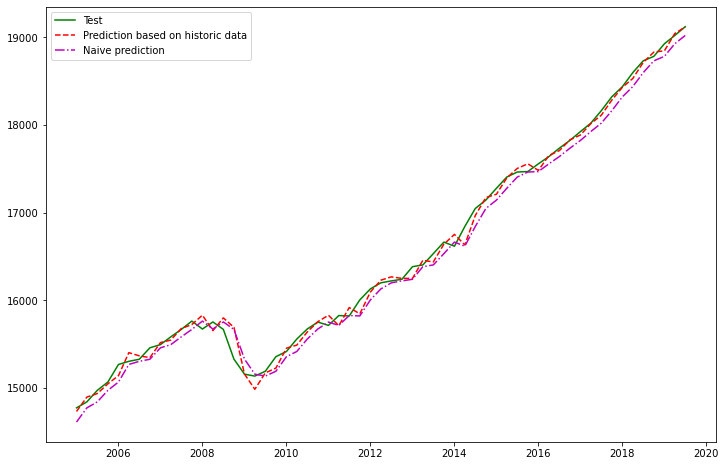

In [61]:
plt.figure(figsize=(12, 8))

#plt.plot(usgdp_train)

plt.plot(usgdp_test, 'g-', label="Test")
plt.plot(pd.Series(prediction, index=usgdp_test.index), 'r--', label="Prediction based on historic data")

# naiwna predykcja to wzięcie po prostu wcześniejszej obserwacji jako predykcji następnej
plt.plot(pd.Series(simple_prediction, index=usgdp_test.index), 'm-.', label="Naive prediction") 

plt.legend()
plt.show()

## Zadanie 1

Napisz funkcję, która znajdzie najlepszy model ARMA - pamiętaj o podziale zbioru na część treningową i testową.

In [9]:
def mse(y, yhat):
    return np.mean((y - yhat)**2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [10]:
# testowanie wytrenowanego modelu

print(mse(usgdp_test.values, predict_test.values))
print(mae(usgdp_test.values, predict_test.values))

16280626.684223467
2739.640028385511


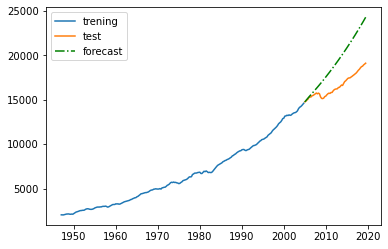

In [62]:
# część testowa odbiega od zachowania części treningowej, stąd duży błąd przewidywania

plt.plot(usgdp_train, label='trening')
plt.plot(usgdp_test, label='test')
plt.plot(predict_test, 'g-.', label='forecast')

plt.legend()
plt.show()

In [12]:
def find_the_best_arma(ts, max_p=10, max_q=10, split=0.8):
    
    k = int(ts.size * split)
    ts_train = ts[:k]
    ts_test = ts[k:]

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    mse2 = np.zeros((max_p, max_q))
    mae2 = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            
            try:
                arma = ARIMA(ts_train, order=(i + 1, 0, j + 1)).fit()
                aic[i, j] = arma.aic
                bic[i, j] = arma.bic
                print('ARIMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))

                arma_pred = arma.predict(start=str(np.min(ts_test.index).year), end=str(np.max(ts_test.index).year), 
                                         dynamic=True)
                
                mse2[i, j] = mse(ts_test.values, arma_pred.values)
                mae2[i, j] = mae(ts_test.values, arma_pred.values)
            
            except:
                aic[i, j] = bic[i, j] = mse2[i, j] = mae2[i, j] = np.Inf
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))
    
    min_mse = np.min(mse2)
    min_arg_mse = np.argwhere(mse2 == min_mse)[0]
    print("MINIMUM MSE=%f dla p=%d, q=%d" % (min_mse, min_arg_mse[0] + 1, min_arg_mse[1] + 1))
    
    min_mae = np.min(mae2)
    min_arg_mae = np.argwhere(mae2 == min_mae)[0]
    print("MINIMUM MAE=%f dla p=%d, q=%d" % (min_mae, min_arg_mae[0] + 1, min_arg_mae[1] + 1))

In [13]:
# używamy tylko części treningowej (z której jest wybierana część walidacyjna)
find_the_best_arma(log_usgdp_train.diff(1), max_p=5, max_q=5)

ARIMA(1, 1): AIC=-1162.758908, BIC=-1149.877485
ARIMA(1, 2): AIC=-1162.935776, BIC=-1146.833997
ARIMA(1, 3): AIC=-1161.672329, BIC=-1142.350194
ARIMA(1, 4): AIC=-1162.650153, BIC=-1140.107662
ARIMA(1, 5): AIC=-1162.594797, BIC=-1136.831951
ARIMA(2, 1): AIC=-1163.118510, BIC=-1147.016731
ARIMA(2, 2): AIC=-1165.945971, BIC=-1146.623836
ARIMA(2, 3): AIC=-1163.765053, BIC=-1141.222562
ARIMA(2, 4): AIC=-1160.762517, BIC=-1134.999670
ARIMA(2, 5): AIC=-1160.629613, BIC=-1131.646411
ARIMA(3, 1): AIC=-1162.387929, BIC=-1143.065794
ARIMA(3, 2): AIC=-1163.263373, BIC=-1140.720883
ARIMA(3, 3): AIC=-1162.499082, BIC=-1136.736235
ARIMA(3, 4): AIC=-1160.219380, BIC=-1131.236178
ARIMA(3, 5): AIC=-1159.003744, BIC=-1126.800186
ARIMA(4, 1): AIC=-1162.318893, BIC=-1139.776403
ARIMA(4, 2): AIC=-1159.850319, BIC=-1134.087472
ARIMA(4, 3): AIC=-1160.468315, BIC=-1131.485113
ARIMA(4, 4): AIC=-1159.444398, BIC=-1127.240840
ARIMA(4, 5): AIC=-1155.162523, BIC=-1119.738609
ARIMA(5, 1): AIC=-1162.732585, BIC=-1136

## Kroswalidacja

Kroswalidacja w szeregach czasowych wygląda nieco inaczej:
- na początek bierzemy pierwszą jedną czwartą zbioru do uczenia i kolejną jedną czwartą do testowego
- następnie bierzemy pierwszą dwie czwarte zbioru do uczenia i kolejną jedną czwartą do testowego
- na koniec pierwszą trzy czwarte zbioru do uczenia i ostatnią jedną czwartą do testowego

TRAIN: (0, 74)
TEST: (75, 146)


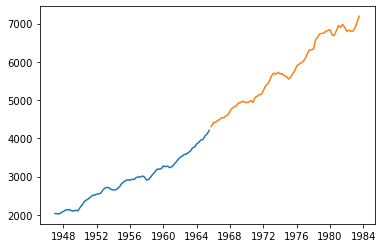

TRAIN: (0, 146)
TEST: (147, 218)


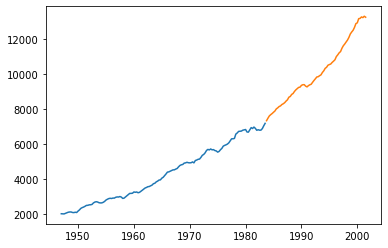

TRAIN: (0, 218)
TEST: (219, 290)


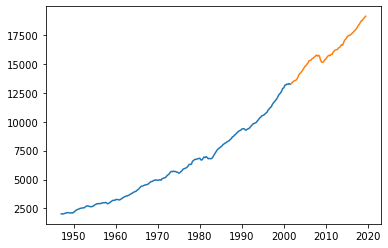

In [14]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(usgdp.values):
    print("TRAIN: (%d, %d)" % (min(train_index), max(train_index)))
    print("TEST: (%d, %d)" % (min(test_index), max(test_index)))
    
    train, test = usgdp.iloc[train_index], usgdp.iloc[test_index]
    plt.plot(train)
    plt.plot(test)
    plt.show()

## Zadanie 2

Napisz funkcję, która znajdzie najlepszy model ARMA - użyj kroswalidacji.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

def find_the_best_arma_crosval(ts, max_p=10, max_q=10, ar=False, cross=5):
    
    tscv = TimeSeriesSplit(n_splits=cross)
    
    aic = np.zeros((max_p + 1, max_q + 1))
    bic = np.zeros((max_p + 1, max_q + 1))
    mae_values = np.zeros((max_p + 1, max_q + 1))
    mse_values = np.zeros((max_p + 1, max_q + 1))
    
    for i in range(max_p + 1):
        for j in range(max_q + 1):
            
            if (i == j == 0):
                aic[0, 0] = bic[0, 0] = mae_values[0, 0] = mse_values[0, 0] = np.Inf
            
            elif (i == 0) | ((not ar) & (j == 0)):
                aic[i, j] = bic[i, j] = mae_values[i, j] = mse_values[i, j] = np.Inf
            
            else:
                
                aic_cross, bic_cross, mse_cross, mae_cross = [], [], [], []
                for train_index, test_index in tscv.split(ts.values):
                    
                    train, test = ts.iloc[train_index], ts.iloc[test_index]
                    arma = ARIMA(train, order=(i, 0, j)).fit()
                    aic_cross.append(arma.aic)
                    bic_cross.append(arma.bic)
                    pred = arma.predict(start=str(np.min(test.index).year), end=str(np.max(test.index).year), dynamic=True)
                    mse_cross.append(mse(test.values, pred.values))
                    mae_cross.append(mae(test.values, pred.values))
                    
                aic[i, j] = np.mean(aic_cross)
                bic[i, j] = np.mean(arma.bic)
                mae_values[i, j] = np.nanmean(mae_cross)
                mse_values[i, j] = np.nanmean(mse_cross)
                print("ARMA(%d, %d): AIC=%f; BIC=%f; MSE=%f; MAE=%f" % (i, j, arma.aic, arma.bic, 
                                                                        mse_values[i, j], mae_values[i, j]))

    print("-" * 30)
    min_aic = np.nanmin(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0] 
    print("MINIMUM AIC=%f for p=%d, q=%d" % (min_aic, min_arg_aic[0], min_arg_aic[1]))
    
    min_bic = np.nanmin(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0] 
    print("MINIMUM BIC=%f for p=%d, q=%d" % (min_bic, min_arg_bic[0], min_arg_bic[1]))
    
    min_mse = np.nanmin(mse_values)
    min_arg_mse = np.argwhere(mse_values == min_mse)[0]
    print("MINIMUM MSE=%f for p=%d, q=%d" % (min_mse, min_arg_mse[0], min_arg_mse[1]))
    
    min_mae = np.nanmin(mae_values)
    min_arg_mae = np.argwhere(mae_values == min_mae)[0]
    print("MINIMUM MAE=%f for p=%d, q=%d" % (min_mae, min_arg_mae[0], min_arg_mae[1]))

In [16]:
find_the_best_arma_crosval(log_usgdp_train.diff(1), max_p=5, max_q=5, ar=False, cross=5)

ARMA(1, 1): AIC=-1227.708148; BIC=-1214.636715; MSE=0.000083; MAE=0.005759
ARMA(1, 2): AIC=-1229.288434; BIC=-1212.949143; MSE=0.000083; MAE=0.005724
ARMA(1, 3): AIC=-1227.009065; BIC=-1207.401916; MSE=0.000082; MAE=0.005642
ARMA(1, 4): AIC=-1228.226202; BIC=-1205.351194; MSE=0.000084; MAE=0.005622
ARMA(1, 5): AIC=-1228.283886; BIC=-1202.141021; MSE=0.000083; MAE=0.005618
ARMA(2, 1): AIC=-1227.216275; BIC=-1210.876984; MSE=0.000083; MAE=0.005794
ARMA(2, 2): AIC=-1229.783144; BIC=-1210.175995; MSE=0.000084; MAE=0.005675
ARMA(2, 3): AIC=-1228.782982; BIC=-1205.907975; MSE=0.000084; MAE=0.005644
ARMA(2, 4): AIC=-1226.287986; BIC=-1200.145120; MSE=0.000084; MAE=0.005737
ARMA(2, 5): AIC=-1226.429784; BIC=-1197.019061; MSE=0.000083; MAE=0.005668
ARMA(3, 1): AIC=-1227.814744; BIC=-1208.207595; MSE=0.000084; MAE=0.005644
ARMA(3, 2): AIC=-1228.710598; BIC=-1205.835591; MSE=0.000084; MAE=0.005652
ARMA(3, 3): AIC=-1228.267644; BIC=-1202.124779; MSE=0.000084; MAE=0.005624
ARMA(3, 4): AIC=-1225.885

# Zadanie: modelowanie ARIMA - case study

Dokonaj analizy szeregu czasowego `AirPassengers`.

In [17]:
air_passengers = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'], index_col='Month')
air_passengers

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


**a) Przekształć szereg do postaci stacjonarnej.**

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     0.8154
p-value             :     0.9919
--------------------------------



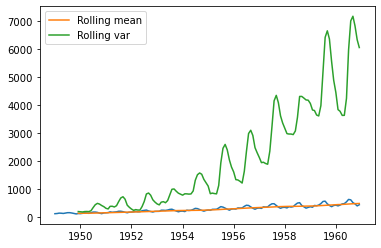

      Autocorrelation plot      
--------------------------------



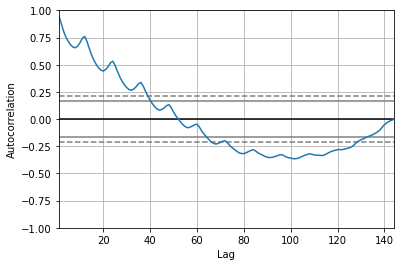

In [18]:
check_time_series_stationary(air_passengers['#Passengers'])

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.4433
p-value             :     0.0002
--------------------------------



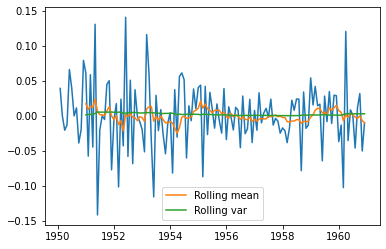

      Autocorrelation plot      
--------------------------------



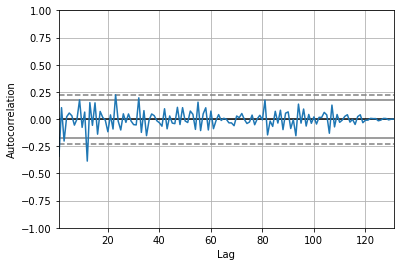

In [19]:
# stabilizacja wariancji, następnie usuwanie trednu i sezonowości

log_air_passengers = np.log(air_passengers)
air_passengers_dec = log_air_passengers.diff(1).diff(12)['#Passengers'].dropna()

check_time_series_stationary(air_passengers_dec)

**b) Dopasuj odpowiedni model za pomocą kroswalidacji dla szeregów czasowych.**

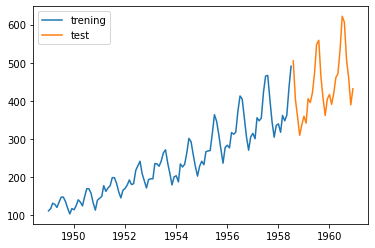

In [20]:
# podział danych na część treningową i testową (split=0.8)

k = int(0.8 * air_passengers['#Passengers'].size)
air_passengers_train, air_passengers_test = air_passengers[:k], air_passengers[k:]

plt.plot(air_passengers_train, label='trening')
plt.plot(air_passengers_test, label='test')

plt.legend()
plt.show()

In [21]:
log_air_passengers_train = np.log(air_passengers_train)

find_the_best_arma_crosval(log_air_passengers_train.diff(1).diff(12), max_p=5, max_q=5, ar=False, cross=5)

ARMA(1, 1): AIC=-263.718295; BIC=-253.460902; MSE=0.002290; MAE=0.032434
ARMA(1, 2): AIC=-261.399600; BIC=-248.577859; MSE=0.002299; MAE=0.032057
ARMA(1, 3): AIC=-263.037406; BIC=-247.651317; MSE=0.002292; MAE=0.032639
ARMA(1, 4): AIC=-262.809473; BIC=-244.859035; MSE=0.002299; MAE=0.032656
ARMA(1, 5): AIC=-260.649415; BIC=-240.134630; MSE=0.002299; MAE=0.032651
ARMA(2, 1): AIC=-264.835275; BIC=-252.013534; MSE=0.002289; MAE=0.032293
ARMA(2, 2): AIC=-261.753747; BIC=-246.367658; MSE=0.002285; MAE=0.032202
ARMA(2, 3): AIC=-261.653899; BIC=-243.703461; MSE=0.002290; MAE=0.032644
ARMA(2, 4): AIC=-260.560717; BIC=-240.045931; MSE=0.002326; MAE=0.032637
ARMA(2, 5): AIC=-259.161870; BIC=-236.082736; MSE=0.002302; MAE=0.031939
ARMA(3, 1): AIC=-263.624228; BIC=-248.238139; MSE=0.002285; MAE=0.032462
ARMA(3, 2): AIC=-262.824226; BIC=-244.873788; MSE=0.002294; MAE=0.032238
ARMA(3, 3): AIC=-262.880939; BIC=-242.366153; MSE=0.002332; MAE=0.032698
ARMA(3, 4): AIC=-258.102591; BIC=-235.023457; MSE=0

In [22]:
# model minimalizujący BIC (model uzyskuje lepszą wyjaśnialność szeregu)

#m4 = ARIMA(endog=log_air_passengers_train, order=(1, 1, 1), trend='t').fit()
m4 = SARIMAX(endog=log_air_passengers_train, order=(1, 1, 1), seasonal_order = (0, 1, 0, 12), trend='c').fit()

m4.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51647D+00    |proj g|=  5.55174D-01

At iterate    5    f= -1.51665D+00    |proj g|=  4.79342D-03

At iterate   10    f= -1.51665D+00    |proj g|=  5.03224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   5.032D-04  -1.517D+00
  F =  -1.5166508810404289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                 174.415
Date:                             Mon, 05 Jun 2023   AIC                           -340.830
Time:                                     21:54:45   BIC                           -330.330
Sample:                                 01-01-1949   HQIC                          -336.578
                                      - 07-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.005      0.034      0.973      -0.009       0.009
ar.L1         -0.3226      0.343     -0.940      0.347      -0.995       0.350
ma.L1          0.0018      0.391      0.004      0.996      -0.764       0.767
sigma2         0.0019      0.000      8.303      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.66
Prob(Q):                              0.99   Prob(JB):                         0.10
Heteroskedasticity (H):               0.15   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Dopasowanie modelu

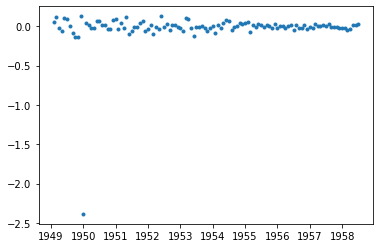

2.1245005953395717

In [23]:
plt.plot(m4.resid[1:], '.')  # pomijamy pierwsze residuum w związku z różnicowaniem szeregu
plt.show()

sm.stats.durbin_watson(m4.resid[1:])  # mieści się w zakresie 1.8 < DW < 2.2

10.723805294763608


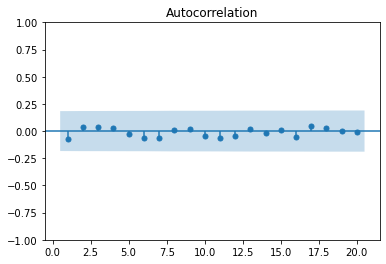

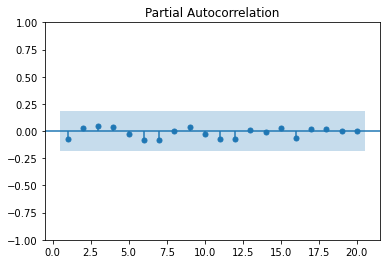

In [24]:
# wartości powinny znajdować się w "pasie"
print(np.sqrt(len(m4.resid)))

plot_acf(m4.resid[1:], lags=20, zero=False)
plot_pacf(m4.resid[1:], lags=20, zero=False)
plt.show()

In [25]:
# reszty nie są normalne

print(stats.shapiro(m4.resid[1:]))
print(stats.normaltest(m4.resid[1:]))

sm.stats.jarque_bera(m4.resid[1:])[:2]

ShapiroResult(statistic=0.21704798936843872, pvalue=5.90318524572364e-22)
NormaltestResult(statistic=236.45781388928816, pvalue=4.506486895261132e-52)


(47587.38197311159, 0.0)

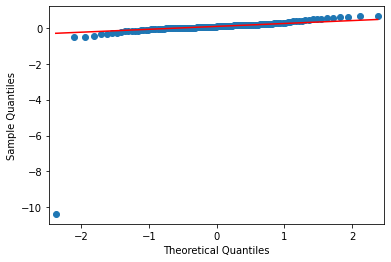

In [42]:
qqplot(m4.resid[1:], line='q', fit=True)
plt.show()  # ogony są normalne

**c) Dokonaj predykcji na zbiorze testowym przy użyciu modelu zbudowanego na zbiorze treningowym.**

In [27]:
# air_passengers_test
predict_test2 = np.exp(m4.predict(start='1958-08-01', end='1960-12-01', dynamic=True))

In [28]:
print(mse(air_passengers_test.values, predict_test2.values))
print(mae(air_passengers_test.values, predict_test2.values))

11081.420444977222
68.40767574246024


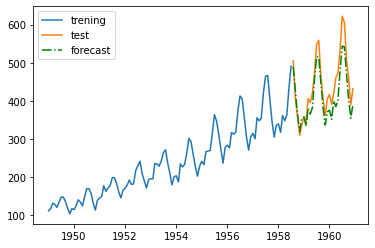

In [29]:
# model bardzo dokładnie przewiduje dane testowe szeregu

plt.plot(air_passengers_train, label='trening')
plt.plot(air_passengers_test, label='test')
plt.plot(predict_test2, 'g-.', label='forecast')

plt.legend()
plt.show()